In [1]:
%matplotlib widget

#from IPython import display
from base64 import b64decode
from pacti import write_contracts_to_file
from pacti.terms.polyhedra import *
from pacti.iocontract import IoContract, Var
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np
from matplotlib import patches
import pdb
from matplotlib.collections import PatchCollection
from contract_utils import *

## Navigation viewpoint modeling

### Uncertainty-generating tasks (CHRG, DSN)

In [2]:
def uncertainty_generating_nav(s: int, noise: tuple[float, float]) -> PolyhedralContract:
  spec = PolyhedralContract.from_string(
    input_vars = [
      f"u{s}_entry",    # initial trajectory estimation uncertainty
      f"r{s}_entry",    # initial relative trajectory distance
    ],
    output_vars = [
      f"u{s}_exit",     # final trajectory estimation uncertainty
      f"r{s}_exit",     # final relative trajectory distance
    ],
    assumptions = [
      # 0 <= u{s}_entry <= 100
      f"-u{s}_entry <= 0",
      f" u{s}_entry <= 100",

      # 0 <= r{s}_entry <= 100
      f"-r{s}_entry <= 0",
      f" r{s}_entry <= 100",
    ],
    guarantees = [
      # upper bound u{s}_exit <= 100
      f"u{s}_exit <= 100",
      
      # noise(min) <= u{exit} - u{entry} <= noise(max)
      f" u{s}_exit - u{s}_entry <=  {noise[1]}",
      f"-u{s}_exit + u{s}_entry <= -{noise[0]}",

      # no change to relative trajectory distance
      f"r{s}_exit - r{s}_entry = 0",
    ])
  return spec


### CHARGING Task

Objective: charge the spacecraft battery

As summarized in [the qualitative impacts table](#qualitative-impacts), this function affects this viewpoint with a fixed impact:
- the spacecraft's attitude change to the Sun injects a small disturbance that increases the trajectory estimation uncertainty.


In [3]:
charging1_nav = uncertainty_generating_nav(s=2, noise=(1.0, 2.0))
print(f"Contract charging1_nav:\n\n{charging1_nav}")

Contract charging1_nav:

InVars: [u2_entry, r2_entry]
OutVars:[u2_exit, r2_exit]
A: [
  -u2_entry <= 0.0
  u2_entry <= 100.0
  -r2_entry <= 0.0
  r2_entry <= 100.0
]
G: [
  u2_exit <= 100.0
  -u2_entry + u2_exit <= 2.0
  u2_entry - u2_exit <= -1.0
  -r2_entry + r2_exit = 0.0
]


### DSN Task

Objective: downlink science data to Earth.

As summarized in [the qualitative impacts table](#qualitative-impacts), this function affects this viewpoint with a fixed impact:
- the spacecraft's attitude change to Earth injects a small disturbance that increases the trajectory estimation uncertainty.

In [4]:
dsn1_nav = uncertainty_generating_nav(s=1, noise=(1.0, 2.0))
print(f"Contract dsn1_nav:\n\n{dsn1_nav}")

Contract dsn1_nav:

InVars: [u1_entry, r1_entry]
OutVars:[u1_exit, r1_exit]
A: [
  -u1_entry <= 0.0
  u1_entry <= 100.0
  -r1_entry <= 0.0
  r1_entry <= 100.0
]
G: [
  u1_exit <= 100.0
  -u1_entry + u1_exit <= 2.0
  u1_entry - u1_exit <= -1.0
  -r1_entry + r1_exit = 0.0
]


### SBO Task

Objective: Acquire small body observations (science data & navigation)

As summarized in [the qualitative impacts table](#qualitative-impacts), this function affects this viewpoint with impacts that are linear with the duration of the task:
- the trajectory estimation error decreases proportionally to an improvement rate.

Note that this task has no impact on the relative trajectory progress.

Contract sbo1_nav:

InVars: [u3_entry, duration_sbo3]
OutVars:[u3_exit]
A: [
  -duration_sbo3 <= 0.0
  u3_entry <= 100.0
]
G: [
  -0.6 duration_sbo3 + u3_entry - u3_exit <= 0.0
  0.4 duration_sbo3 - u3_entry + u3_exit <= 0.0
  -u3_exit <= 0.0
]


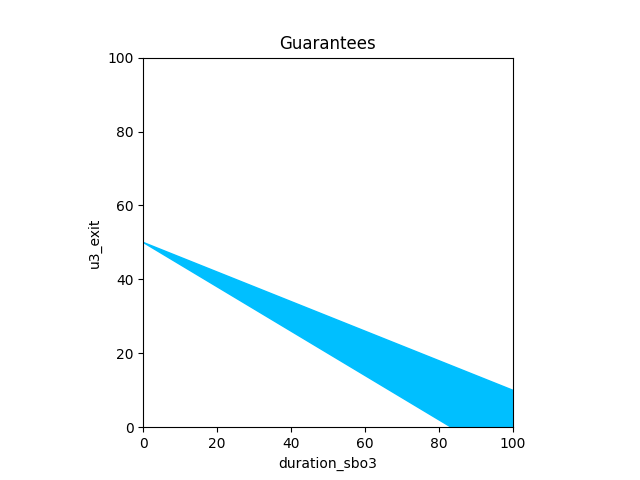

In [5]:
# Parameters:
# - s: start index of the timeline variables
# - improvement: rate of trajectory estimation uncertainty improvement during the task instance
def SBO_nav_uncertainty(s: int, improvement: tuple[float, float]) -> PolyhedralContract:
  spec = PolyhedralContract.from_string(
    input_vars = [
      f"u{s}_entry",      # initial trajectory uncertainty
      f"duration_sbo{s}", # knob variable for SBO duration
    ],
    output_vars = [
      f"u{s}_exit",       # final trajectory uncertainty
    ],
    assumptions = [
      # Task has a positive scheduled duration
      f"-duration_sbo{s} <= 0",

      # Upper-bound on the trajectory estimation uncertainty
      f"u{s}_entry <= 100",
    ],
    guarantees = [
      # upper bound u{s}_exit <= 100
      f"u{s}_exit <= 100",
      
      # duration*improvement(min) <= u{entry} - u{exit} <= duration*improvement(max)
      f" u{s}_entry - u{s}_exit - {improvement[1]}*duration_sbo{s} <= 0",
      f"-u{s}_entry + u{s}_exit + {improvement[0]}*duration_sbo{s} <= 0",

      # Lower-bound on the trajectory estimation uncertainty
      f"-u{s}_exit <= 0",
    ])
  return spec

sbo1_nav_uncertainty = SBO_nav_uncertainty(s=3, improvement=(0.4, 0.6))
print(f"Contract sbo1_nav:\n\n{sbo1_nav_uncertainty}")

_ = plot_guarantees(contract=sbo1_nav_uncertainty,
                x_var=Var("duration_sbo3"),
                y_var=Var("u3_exit"),
                var_values={
                  Var("u3_entry"):50,
                },
                x_lims=(0,100),
                y_lims=(0,100))

In [6]:
sbo1_nav_progress = nochange_contract(s=3, name="r")
print(f"sbo_nav_progress:\n{sbo1_nav_progress}")

sbo_nav_progress:
InVars: [r3_entry]
OutVars:[r3_exit]
A: [
  
]
G: [
  -r3_entry + r3_exit = 0.0
]


In [7]:
sbo1_nav = sbo1_nav_uncertainty.merge(sbo1_nav_progress)
print(f"sbo1_nav:\n{sbo1_nav}")

sbo1_nav:
InVars: [u3_entry, duration_sbo3, r3_entry]
OutVars:[u3_exit, r3_exit]
A: [
  -duration_sbo3 <= 0.0
  u3_entry <= 100.0
]
G: [
  -0.6 duration_sbo3 + u3_entry - u3_exit <= 0.0
  0.4 duration_sbo3 - u3_entry + u3_exit <= 0.0
  -u3_exit <= 0.0
  -r3_entry + r3_exit = 0.0
]


#### TCM Task (Perform a Trajectory Correction Maneuver)

Objective: Perform a delta-V maneuver to bring the spacecraft trajectory closer to that of the small body.

As described in [the qualitative impacts table](#qualitative-impacts), this function affects three viewpoints, each with impacts that are linear with the duration of the task:
- The navigation trajectory improves by a delta during the delta-V subtask.

Note: the heating subtask has no impact on navigation.

##### TCM Heating SubTask

Since TCM Heating has no impact on navigation, we use the no-change contract utility to specify this property for the two navigation viewpoint state variables: `u` and `r`.

In [8]:
tcm1_nav_heating = nochange_contract(s=4, name="u").merge(nochange_contract(s=4, name="r"))
print(f"sbo_nav_progress:\n{tcm1_nav_heating}")

sbo_nav_progress:
InVars: [u4_entry, r4_entry]
OutVars:[u4_exit, r4_exit]
A: [
  
]
G: [
  -u4_entry + u4_exit = 0.0
  -r4_entry + r4_exit = 0.0
]


##### TCM DeltaV SubTask

Contract tcm1_nav_deltav_uncertainty:

InVars: [u5_entry, duration_tcm_deltav5]
OutVars:[u5_exit]
A: [
  -duration_tcm_deltav5 <= 0.0
  -u5_entry <= 0.0
  u5_entry <= 100.0
]
G: [
  u5_exit <= 100.0
  -1.6 duration_tcm_deltav5 - u5_entry + u5_exit <= 0.0
  1.5 duration_tcm_deltav5 + u5_entry - u5_exit <= 0.0
]


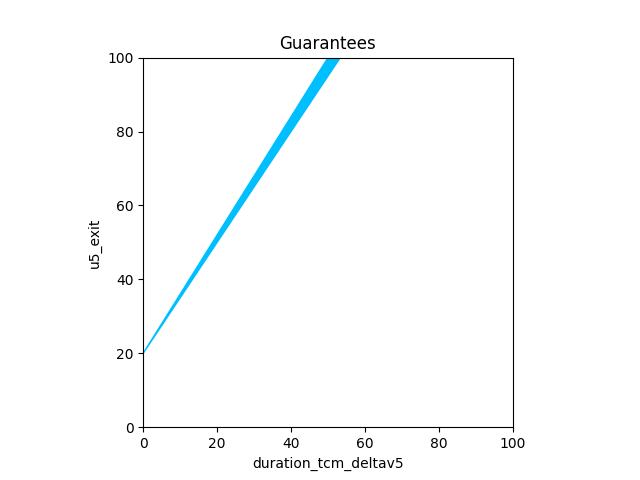

In [9]:
def TCM_navigation_deltav_uncertainty(s: int, noise: tuple[float, float]) -> PolyhedralContract:
  spec = PolyhedralContract.from_string(
    input_vars = [
      f"u{s}_entry",              # initial trajectory estimation uncertainty
      f"duration_tcm_deltav{s}",  # knob variable for TCM deltav duration

    ],
    output_vars = [
      f"u{s}_exit",               # final trajectory estimation uncertainty
    ],
    assumptions = [
      # Task has a positive scheduled duration
      f"-duration_tcm_deltav{s} <= 0",

      # 0 <= u{s}_entry <= 100
      f"-u{s}_entry <= 0",
      f" u{s}_entry <= 100",
    ],
    guarantees = [
      # upper bound u{s}_exit <= 100
      f"u{s}_exit <= 100",
      
      # noise(min) <= u{exit} - u{entry} <= noise(max)
      f" u{s}_exit - u{s}_entry - {noise[1]} duration_tcm_deltav{s} <= 0",
      f"-u{s}_exit + u{s}_entry + {noise[0]} duration_tcm_deltav{s} <= 0",
    ])
  return spec

tcm1_nav_deltav_uncertainty = TCM_navigation_deltav_uncertainty(s=5, noise=(1.5, 1.6))
print(f"Contract tcm1_nav_deltav_uncertainty:\n\n{tcm1_nav_deltav_uncertainty}")

_ = plot_guarantees(contract=tcm1_nav_deltav_uncertainty,
                x_var=Var("duration_tcm_deltav5"),
                y_var=Var("u5_exit"),
                var_values={
                  Var("u5_entry"):20,
                },
                x_lims=(0,100),
                y_lims=(0,100))

Contract tcm1_navigation_deltav_progress:

InVars: [r5_entry, duration_tcm_deltav5]
OutVars:[r5_exit]
A: [
  r5_entry <= 100.0
]
G: [
  -0.5 duration_tcm_deltav5 + r5_entry - r5_exit <= 0.0
  0.4 duration_tcm_deltav5 - r5_entry + r5_exit <= 0.0
  -r5_exit <= 0.0
]


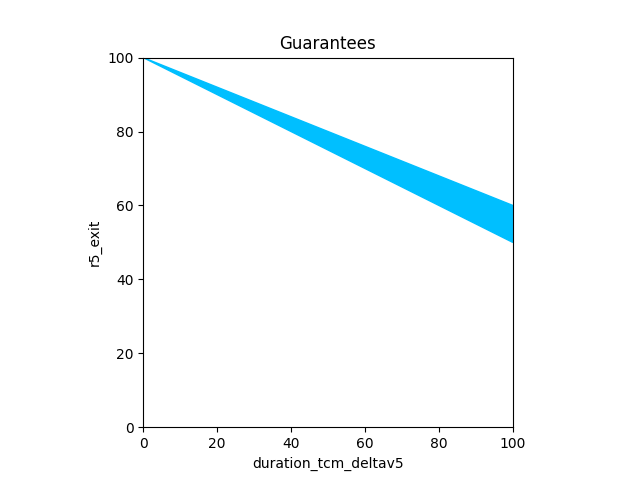

In [10]:
def TCM_navigation_deltav_progress(s: int, progress: tuple[float, float]) -> PolyhedralContract:
  spec = PolyhedralContract.from_string(
    input_vars = [
      f"r{s}_entry",              # initial trajectory relative distance
      f"duration_tcm_deltav{s}",  # knob variable for TCM deltav duration
    ],
    output_vars = [
      f"r{s}_exit",               # final trajectory relative distance
    ],
    assumptions = [
      # upper bound on trajectory relative distance
      f"r{s}_entry <= 100",
    ],
    guarantees = [
      # duration*improvement(min) <= r{entry} - r{exit} <= duration*improvement(max)
      f" r{s}_entry - r{s}_exit - {progress[1]}*duration_tcm_deltav{s} <= 0",
      f"-r{s}_entry + r{s}_exit + {progress[0]}*duration_tcm_deltav{s} <= 0",

      # lower bound on trajectory relative distance
      f"-r{s}_exit <= 0",
    ])
  return spec

tcm1_nav_deltav_progress = TCM_navigation_deltav_progress(s=5, progress=(0.4, 0.5))
print(f"Contract tcm1_navigation_deltav_progress:\n\n{tcm1_nav_deltav_progress}")

_ = plot_guarantees(contract=tcm1_nav_deltav_progress,
                x_var=Var("duration_tcm_deltav5"),
                y_var=Var("r5_exit"),
                var_values={
                  Var("r5_entry"):100,
                },
                x_lims=(0,100),
                y_lims=(0,100))

In [11]:
tcm1_nav_deltav = tcm1_nav_deltav_uncertainty.merge(tcm1_nav_deltav_progress)
print(f"Contract tcm1_nav_deltav:\n\n{tcm1_nav_deltav}")

Contract tcm1_nav_deltav:

InVars: [u5_entry, duration_tcm_deltav5, r5_entry]
OutVars:[u5_exit, r5_exit]
A: [
  -duration_tcm_deltav5 <= 0.0
  -u5_entry <= 0.0
  u5_entry <= 100.0
  r5_entry <= 100.0
]
G: [
  u5_exit <= 100.0
  -1.6 duration_tcm_deltav5 - u5_entry + u5_exit <= 0.0
  1.5 duration_tcm_deltav5 + u5_entry - u5_exit <= 0.0
  -0.5 duration_tcm_deltav5 + r5_entry - r5_exit <= 0.0
  0.4 duration_tcm_deltav5 - r5_entry + r5_exit <= 0.0
  -r5_exit <= 0.0
]


In [12]:
tcm1_nav = scenario_sequence(c1=tcm1_nav_heating, c2=tcm1_nav_deltav, variables=["u", "r"], c1index=4)
print(f"Contract tcm1_nav:\n\n{tcm1_nav}")

Contract tcm1_nav:

InVars: [u4_entry, r4_entry, duration_tcm_deltav5]
OutVars:[u5_exit, r5_exit, output_u4, output_r4]
A: [
  -duration_tcm_deltav5 <= 0.0
  -u4_entry <= 0.0
  u4_entry <= 100.0
  r4_entry <= 100.0
]
G: [
  output_u4 - u4_entry = 0.0
  output_r4 - r4_entry = 0.0
  u5_exit <= 100.0
  -1.6 duration_tcm_deltav5 - output_u4 + u5_exit <= 0.0
  1.5 duration_tcm_deltav5 + output_u4 - u5_exit <= 0.0
  -0.5 duration_tcm_deltav5 + output_r4 - r5_exit <= 0.0
  0.4 duration_tcm_deltav5 - output_r4 + r5_exit <= 0.0
  -r5_exit <= 0.0
]


### Navigation Schedule Analysis

Let's consider a simple 4-step schedule of the following sequence of task instances, which we compose:
- DSN
- CHARGING
- SBO
- TCM

In [13]:
steps12=scenario_sequence(c1=dsn1_nav, c2=charging1_nav, variables=["u", "r"], c1index=1)
print(f"---- Steps 1,2\n{steps12}")
print(steps12.get_variable_bounds("output_u1"))
print(steps12.get_variable_bounds("output_r1"))

---- Steps 1,2
InVars: [u1_entry, r1_entry]
OutVars:[u2_exit, r2_exit, output_u1, output_r1]
A: [
  -u1_entry <= 0.0
  u1_entry <= 100.0
  -r1_entry <= 0.0
  r1_entry <= 100.0
]
G: [
  output_u1 - u1_entry <= 2.0
  -output_u1 + u1_entry <= -1.0
  output_r1 - r1_entry = 0.0
  u2_exit <= 100.0
  -output_u1 + u2_exit <= 2.0
  output_u1 - u2_exit <= -1.0
  -output_r1 + r2_exit = 0.0
]
(1.0, 99.0)
(0.0, 100.0)


In [14]:
steps123=scenario_sequence(c1=steps12, c2=sbo1_nav, variables=["u", "r"], c1index=2)
print(f"---- Steps 1,2,3\n{steps123}")
print(steps123.get_variable_bounds("output_u2"))
print(steps123.get_variable_bounds("output_r2"))

---- Steps 1,2,3
InVars: [u1_entry, r1_entry, duration_sbo3]
OutVars:[output_u1, output_r1, u3_exit, r3_exit, output_u2, output_r2]
A: [
  -duration_sbo3 <= 0.0
  -u1_entry <= 0.0
  u1_entry <= 100.0
  -r1_entry <= 0.0
  r1_entry <= 100.0
]
G: [
  output_u1 - u1_entry <= 2.0
  -output_u1 + u1_entry <= -1.0
  output_r1 - r1_entry = 0.0
  output_u2 <= 100.0
  -output_u1 + output_u2 <= 2.0
  output_u1 - output_u2 <= -1.0
  -output_r1 + output_r2 = 0.0
  -0.6 duration_sbo3 + output_u2 - u3_exit <= 0.0
  0.4 duration_sbo3 - output_u2 + u3_exit <= 0.0
  -u3_exit <= 0.0
  -output_r2 + r3_exit = 0.0
]
(2.0, 100.0)
(0.0, 100.0)


In [15]:
steps1234=scenario_sequence(c1=steps123, c2=tcm1_nav, variables=["u", "r"], c1index=3)
print(f"---- Steps 1,2,3,4\n{steps1234}")
print(steps1234.get_variable_bounds("output_u3"))
print(steps1234.get_variable_bounds("output_r3"))
print(steps1234.get_variable_bounds("duration_tcm_deltav5"))

---- Steps 1,2,3,4
InVars: [u1_entry, r1_entry, duration_sbo3, duration_tcm_deltav5]
OutVars:[output_u1, output_r1, output_u2, output_r2, u5_exit, r5_exit, output_u4, output_r4, output_u3, output_r3]
A: [
  -duration_tcm_deltav5 <= 0.0
  -duration_sbo3 <= 0.0
  -u1_entry <= 0.0
  u1_entry <= 100.0
  -r1_entry <= 0.0
  r1_entry <= 100.0
]
G: [
  output_u1 - u1_entry <= 2.0
  -output_u1 + u1_entry <= -1.0
  output_r1 - r1_entry = 0.0
  output_u2 <= 100.0
  -output_u1 + output_u2 <= 2.0
  output_u1 - output_u2 <= -1.0
  -output_r1 + output_r2 = 0.0
  -0.6 duration_sbo3 + output_u2 - output_u3 <= 0.0
  0.4 duration_sbo3 - output_u2 + output_u3 <= 0.0
  -output_u3 <= 0.0
  -output_r2 + output_r3 = 0.0
  -output_u3 + output_u4 = 0.0
  -output_r3 + output_r4 = 0.0
  u5_exit <= 100.0
  -1.6 duration_tcm_deltav5 - output_u4 + u5_exit <= 0.0
  1.5 duration_tcm_deltav5 + output_u4 - u5_exit <= 0.0
  -0.5 duration_tcm_deltav5 + output_r4 - r5_exit <= 0.0
  0.4 duration_tcm_deltav5 - output_r4 + r5

In [16]:
scenario_nav=steps1234.rename_variables([
    ("u4_exit", "output_u4"), 
    ("r4_exit", "output_r4"),
    ("u5_exit", "output_u5"), 
    ("r5_exit", "output_r5")])
print(f"scenario_nav={scenario_nav}")

scenario_nav=InVars: [u1_entry, r1_entry, duration_sbo3, duration_tcm_deltav5]
OutVars:[output_u1, output_r1, output_u2, output_r2, output_u4, output_r4, output_u3, output_r3, output_u5, output_r5]
A: [
  -duration_tcm_deltav5 <= 0.0
  -duration_sbo3 <= 0.0
  -u1_entry <= 0.0
  u1_entry <= 100.0
  -r1_entry <= 0.0
  r1_entry <= 100.0
]
G: [
  output_u1 - u1_entry <= 2.0
  -output_u1 + u1_entry <= -1.0
  output_r1 - r1_entry = 0.0
  output_u2 <= 100.0
  -output_u1 + output_u2 <= 2.0
  output_u1 - output_u2 <= -1.0
  -output_r1 + output_r2 = 0.0
  -0.6 duration_sbo3 + output_u2 - output_u3 <= 0.0
  0.4 duration_sbo3 - output_u2 + output_u3 <= 0.0
  -output_u3 <= 0.0
  -output_r2 + output_r3 = 0.0
  -output_u3 + output_u4 = 0.0
  -output_r3 + output_r4 = 0.0
  output_u5 <= 100.0
  -1.6 duration_tcm_deltav5 - output_u4 + output_u5 <= 0.0
  1.5 duration_tcm_deltav5 + output_u4 - output_u5 <= 0.0
  -0.5 duration_tcm_deltav5 + output_r4 - output_r5 <= 0.0
  0.4 duration_tcm_deltav5 - output_r

In [17]:
write_contracts_to_file(contracts=[scenario_nav], names=["scenario_nav"], file_name="json/scenario_nav.json")